<a href="https://colab.research.google.com/github/taha2002/HVDC-ML/blob/main/HVDC%20(pole%20to%20ground)%20Fault%20Diagnosis%20using%20Machine%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://figshare.com/ndownloader/articles/25257001/versions/3 -O data.zip
!unzip -qq data.zip -d data

--2025-03-28 14:41:07--  https://figshare.com/ndownloader/articles/25257001/versions/3
Resolving figshare.com (figshare.com)... 52.49.122.173, 52.17.159.36, 52.30.109.106, ...
Connecting to figshare.com (figshare.com)|52.49.122.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24263078 (23M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  23.14M  14.9MB/s    in 1.6s    

2025-03-28 14:41:09 (14.9 MB/s) - ‘data.zip’ saved [24263078/24263078]



In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

excel_file_path = "/content/data/Four terminal HVDC test system current and voltage (pole to ground fault).xlsx"  #  Data file path

# Fault distances in the exel file
fault_distances = [4, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 198]

# Dictionary to store data from each sheet
# Keys are labels, values are DataFrames
sheet_data_dict = {
    "idc13n": pd.read_excel(excel_file_path, sheet_name="Sheet1", header=None), # Current data, negative pole
    "idc13p": pd.read_excel(excel_file_path, sheet_name="Sheet2", header=None), # Current data, positive pole
    "vdc13p": pd.read_excel(excel_file_path, sheet_name="Sheet3", header=None), # Voltage data, positive pole
    "vdc13n": pd.read_excel(excel_file_path, sheet_name="Sheet4", header=None)  # Voltage data, negative pole
}

In [3]:
# Define the range of rows containing data
START_ROW = 6
END_ROW = 509

# List to store extracted features
extracted_features = []

for data_label, raw_dataframe in sheet_data_dict.items():
    df_data = raw_dataframe.iloc[START_ROW:END_ROW].reset_index(drop=True)

    for i, dist in enumerate(fault_distances):
        # Extract subset of data for the current distance
        start_col = i * 24
        end_col = start_col + 23
        sub_df = df_data.iloc[:, start_col:end_col].copy()

        # Data Cleaning
        sub_df = sub_df.dropna(axis='columns', how='all')
        sub_df = sub_df.dropna(axis='rows', how='all')
        sub_df = sub_df.apply(pd.to_numeric, errors='coerce')
        sub_df = sub_df.dropna(axis='rows', how='all').reset_index(drop=True)

        for col in sub_df.columns:
            series = sub_df[col].dropna()
            if not series.empty:
                # Calculate and store features
                features = {
                    "distance": dist,
                    "sample_index": col - start_col,
                    f"{data_label}_mean": series.mean(),
                    f"{data_label}_std": series.std(),
                    f"{data_label}_min": series.min(),
                    f"{data_label}_max": series.max(),
                }
                extracted_features.append(features)

# Create a DataFrame from the extracted features
all_features_df = pd.DataFrame(extracted_features)

In [4]:
# Group the DataFrame by 'distance' and 'sample_index'
df_merged = all_features_df.groupby(['distance', 'sample_index']).agg(
    lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan
).reset_index()

# Remove rows with any NaN values
df_merged = df_merged.dropna()

In [5]:
#full data length is 483
len(df_merged)

483

In [6]:
df_merged.head(10)

,distance,sample_index,idc13n_mean,idc13n_std,idc13n_min,idc13n_max,idc13p_mean,idc13p_std,idc13p_min,idc13p_max,vdc13p_mean,vdc13p_std,vdc13p_min,vdc13p_max,vdc13n_mean,vdc13n_std,vdc13n_min,vdc13n_max
0,4,0,-1.175677,0.583692,-2.018366,-0.066694,7.669451,2.697186,0.784425,10.999193,3.215489,37.141500,-294.418532,318.437014,-504.532140,141.476608,-792.295004,-321.778002
1,4,1,-1.389766,0.274611,-1.800965,-0.783191,7.239544,2.493249,0.784425,10.171428,53.186660,26.700118,-158.757835,318.437014,-496.323131,124.923615,-705.891444,-321.799491
2,4,2,-1.234563,0.226381,-1.571770,-0.783157,5.579988,1.769004,0.784425,7.771661,115.744998,30.331706,-12.106234,318.437014,-452.644485,92.193617,-609.219991,-321.819233
3,4,3,-1.108204,0.181195,-1.373622,-0.783121,4.251429,1.223691,0.784425,5.844555,167.949356,31.983793,92.197153,318.437014,-416.925539,66.143308,-530.941691,-321.831132
4,4,4,-0.988976,0.130522,-1.192220,-0.783067,3.017855,0.757814,0.784425,4.106448,218.664439,28.241393,160.857773,318.437014,-383.338868,42.215378,-457.635131,-321.839777
5,4,5,-0.946833,0.110485,-1.120899,-0.782235,2.589010,0.606349,0.784425,3.492550,236.874634,25.298635,185.946528,318.437014,-371.608229,33.979692,-432.054708,-321.842326
6,4,6,-0.931173,0.102623,-1.093252,-0.776401,2.430648,0.551607,0.784425,3.263453,243.685773,23.957214,195.784442,318.437014,-367.277993,30.959445,-422.610451,-321.843214
7,4,7,-0.918034,0.095799,-1.069642,-0.771941,2.297712,0.506075,0.784425,3.070023,249.446364,22.716897,204.292084,318.437014,-363.645969,28.435354,-414.677145,-321.843871
8,4,8,-0.906858,0.089824,-1.049280,-0.768492,2.184527,0.467593,0.784425,2.904493,254.382832,21.575768,211.718619,318.437014,-360.556363,26.294844,-407.922233,-321.844276
9,4,9,-0.897242,0.084551,-1.031533,-0.765803,2.086995,0.434624,0.784425,2.761272,258.661755,20.527982,218.258750,318.437014,-357.895648,24.456613,-402.101875,-321.844361


## data visualization

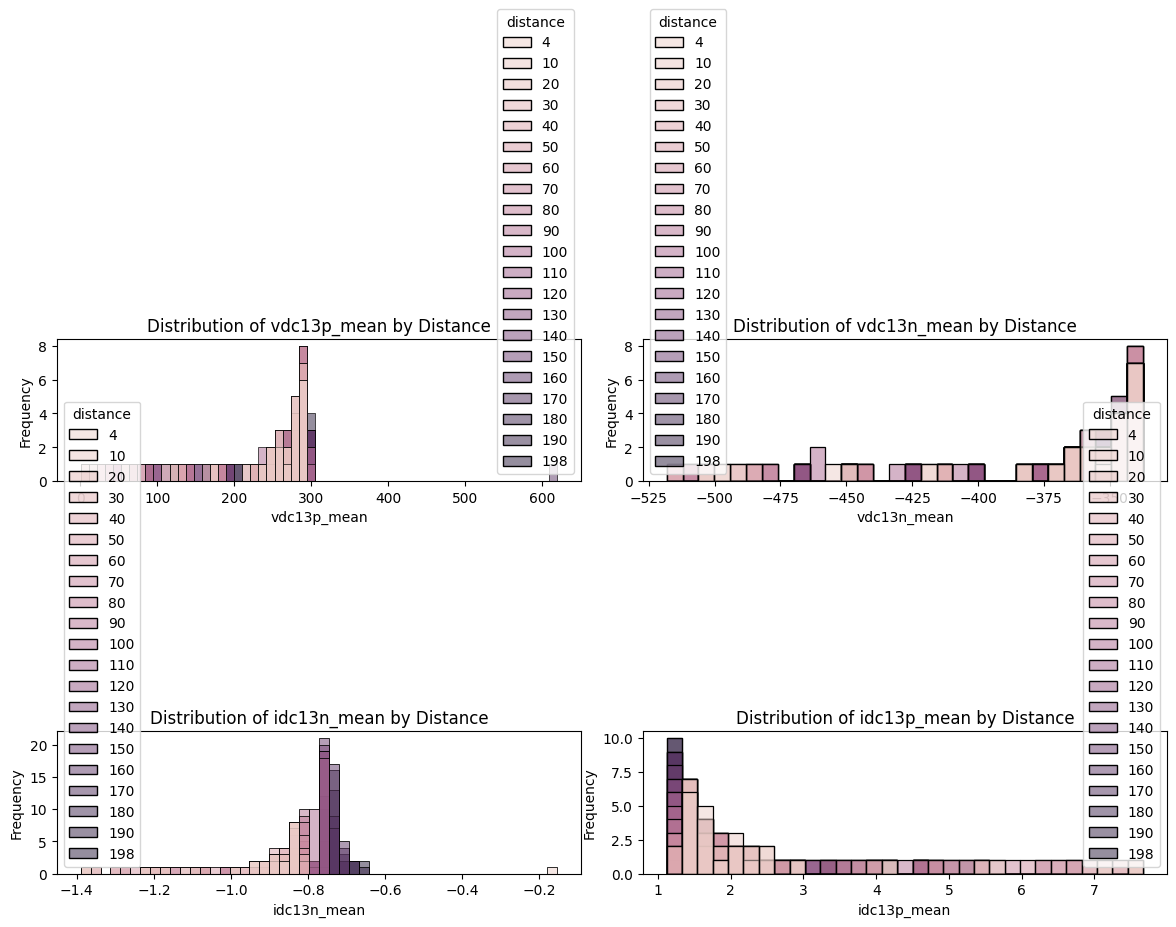

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of features to visualize
features_to_visualize = [
    "vdc13p_mean",  # Voltage data, positive pole
    "vdc13n_mean",  # Voltage data, negative pole
    "idc13n_mean",  # Current data, negative pole
    "idc13p_mean"   # Current data, positive pole
]

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, feature in enumerate(features_to_visualize):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.histplot(data=all_features_df, x=feature, hue="distance", ax=ax)
    ax.set_title(f"Distribution of {feature} by Distance")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

###Data Splitting and Scaling

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_merged.drop(["distance", "sample_index"], axis=1)
y = df_merged["distance"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

###Model Training and Evaluation

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=9, min_samples_split=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results[name] = {"model": model, "accuracy": accuracy, "report": report}
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

--- Logistic Regression ---
Accuracy: 0.5361
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         4
          10       0.12      0.25      0.17         4
          20       0.57      0.80      0.67         5
          30       0.80      1.00      0.89         4
          40       1.00      0.60      0.75         5
          50       0.25      0.25      0.25         4
          60       0.33      0.20      0.25         5
          70       0.00      0.00      0.00         5
          80       0.00      0.00      0.00         4
          90       0.27      0.60      0.38         5
         100       1.00      1.00      1.00         5
         110       0.40      1.00      0.57         4
         120       0.00      0.00      0.00         5
         130       0.60      0.60      0.60         5
         140       1.00      0.20      0.33         5
         150       0.67      1.00      0.80         4
         160       1.00      1.00   

###Visualization and Reporting

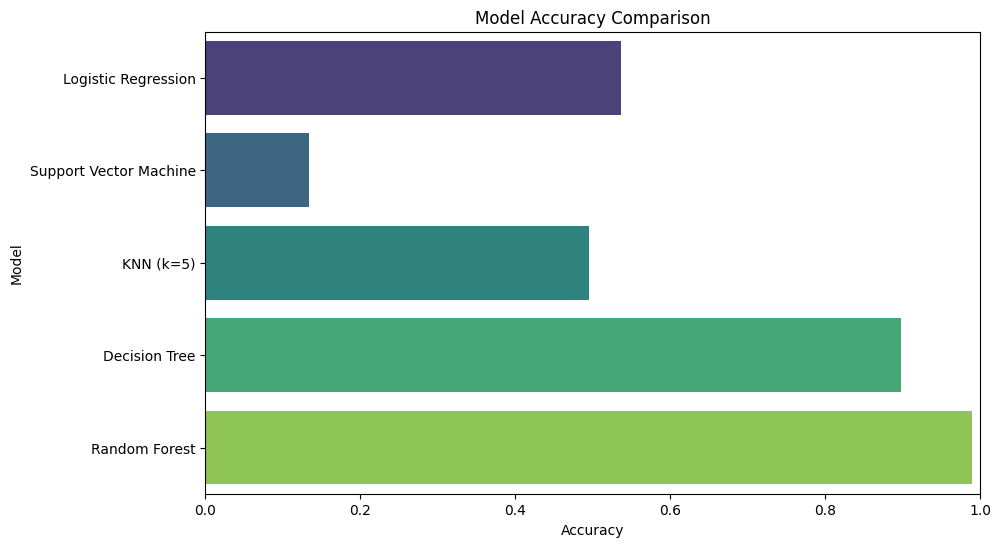

In [10]:
# Accuracy Comparison Plot
accuracies = [result["accuracy"] for result in results.values()]
model_names = list(models.keys())

plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.show()


###Confusion Matrix for the Best Model

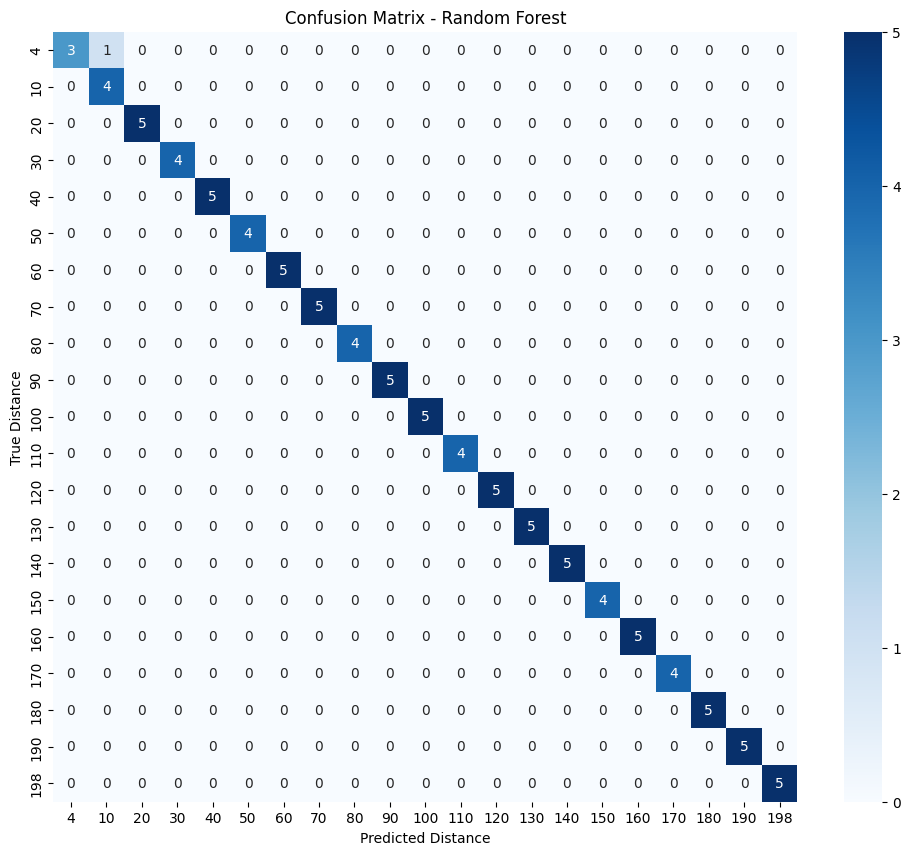

In [11]:
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
y_pred_best = best_model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=fault_distances, yticklabels=fault_distances)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted Distance")
plt.ylabel("True Distance")
plt.show()

###Feature Importance for the Best Model

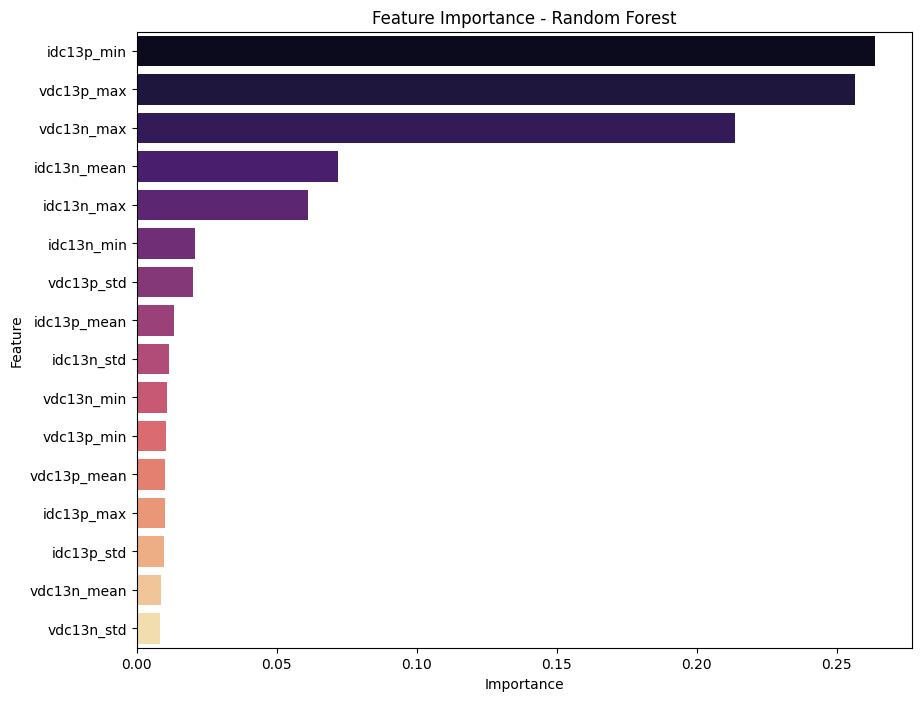

In [12]:
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="magma")
    plt.title(f'Feature Importance - {best_model_name}')
    plt.show()

### **Confusion matrices for all the models**

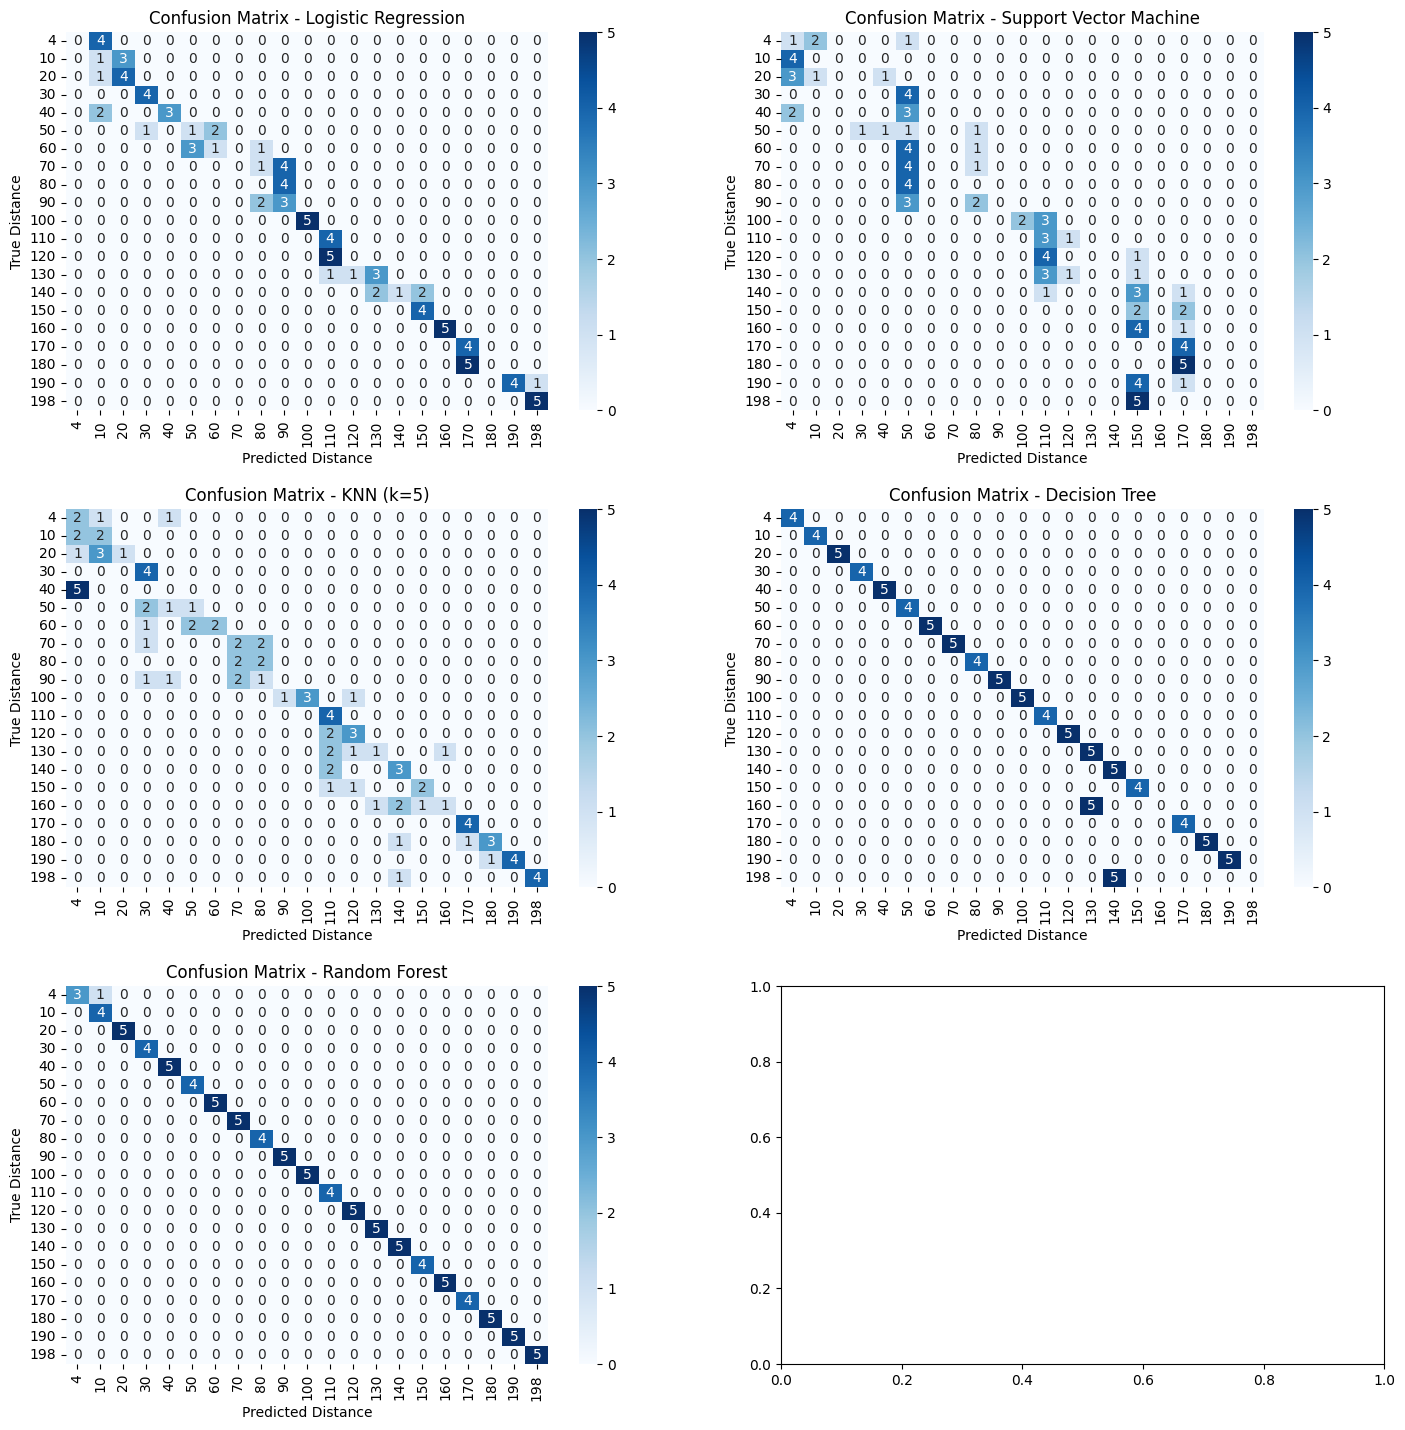

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

num_models = len(models)
fig, axes = plt.subplots(num_models // 2 + num_models % 2, 2, figsize=(15, 5 * (num_models // 2 + num_models % 2)))
fig.tight_layout(pad=5.0)


# Loop through models to create confusion matrices
model_index = 0
for model_name, model_data in results.items():
    # Get predictions for the current model
    y_pred = model_data['model'].predict(X_test_scaled)

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    row = model_index // 2
    col = model_index % 2
    ax = axes[row, col] if num_models > 2 else axes[model_index]

    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=fault_distances, yticklabels=fault_distances, ax=ax)
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted Distance")
    ax.set_ylabel("True Distance")

    model_index += 1

plt.show()



```
```



   

```
```



###Analyzing Misclassifications


In [14]:
import pandas as pd

# Ensure y_test is a pandas Series
y_test = pd.Series(y_test)

# Get the indices of misclassified samples
misclassified_indices = np.where(y_test != y_pred_best)[0]

# Analyze the features of misclassified samples
misclassified_samples = X_test.iloc[misclassified_indices]

# Print some information about misclassified samples
for i in misclassified_indices:
    print(f"Sample {i}: True Distance = {y_test.iloc[i]}, Predicted Distance = {y_pred_best[i]}")
    print(f"Features: {X_test.iloc[i]}")
    print("-" * 20)

Sample 36: True Distance = 4, Predicted Distance = 10
Features: idc13n_mean     -1.175677
idc13n_std       0.583692
idc13n_min      -2.018366
idc13n_max      -0.066694
idc13p_mean      7.669451
idc13p_std       2.697186
idc13p_min       0.784425
idc13p_max      10.999193
vdc13p_mean      3.215489
vdc13p_std      37.141500
vdc13p_min    -294.418532
vdc13p_max     318.437014
vdc13n_mean   -504.532140
vdc13n_std     141.476608
vdc13n_min    -792.295004
vdc13n_max    -321.778002
Name: 0, dtype: float64
--------------------


###Predicting Fault Distance on privous Sample

In [15]:
def predict_fault_distance(model, input_data, actual_distance):
  """Predicts the fault distance and returns predicted and actual values."""

  # Make a prediction using the trained model
  prediction = model.predict(scaler.transform(input_data))

  return prediction[0], actual_distance

sample_index = 5
sample_data = df_merged.drop(["distance", "sample_index"], axis=1).iloc[[sample_index]].values
actual_distance = df_merged["distance"].iloc[sample_index]

predicted_distance, actual_distance = predict_fault_distance(best_model, sample_data, actual_distance)

print(f"Predicted fault distance: {predicted_distance}")
print(f"Actual fault distance: {actual_distance}")

Predicted fault distance: 4
Actual fault distance: 4


### Predicting Fault Distance for New Values

In [16]:
import numpy as np

feature_values = {
    "idc13n_mean": 1.23,
    "idc13n_std": 0.45,
    "idc13n_min": 0.87,
    "idc13n_max": 1.67,
    "idc13p_mean": -1.12,
    "idc13p_std": 0.32,
    "idc13p_min": -1.45,
    "idc13p_max": -0.98,
    "vdc13p_mean": 498.56,
    "vdc13p_std": 2.34,
    "vdc13p_min": 495.23,
    "vdc13p_max": 501.89,
    "vdc13n_mean": -497.87,
    "vdc13n_std": 2.12,
    "vdc13n_min": -500.98,
    "vdc13n_max": -494.76,
}

input_data = np.array([value for value in feature_values.values()]).reshape(1, -1)

predicted_distance = best_model.predict(scaler.transform(input_data))[0]

print(f"Predicted fault distance: {predicted_distance}")

Predicted fault distance: 160
